In [1]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re
import os
sns.set_theme(style="whitegrid")
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [4]:
def populateDataLog(input_dir):
    dataLog={}
    for file in os.listdir(input_dir):
        if file != ".DS_Store":
            lossArray = []
            gapArray = []
            localGapArray =[]
            a=open(input_dir+file, "r").read().replace("0>", "").split("\n")
            for item in a:
                try:
                    b=item.strip().replace(":", "").split()
                    loss, gap, local_gap = b[2],b[4], b[-1]
                    lossArray.append(loss)
                    gapArray.append(gap)
                    localGapArray.append(local_gap)
                except:
                    pass
            dataLog[file]={
                "lossArray" :lossArray,
                "gapArray" : gapArray,
                "localGapArray" : localGapArray
            }
    return dataLog

def read_result_from_txt(path):
    files = os.listdir(path)
    #data_file = [file
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            with open(path+file,'r') as f:
                lines = f.readlines()
            result = [line for line in lines if line.startswith("t_")]
            losses = np.zeros(len(result))
            gap = np.zeros(len(result))
            for k,v in enumerate(result):
                modified = re.split('[\n : ]',v)
                #print(modified[4])
                losses[k] = float(modified[6])
                gap[k] = float(modified[10])
            dataLog[int(file.split("-")[1])] = {"losses":losses,
                      "gap":gap}
    return dataLog

def read_result_from_csv(path):
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            try:
                pd_file = pd.read_csv(os.path.join(path,file), index_col=0)
                dataLog[str(file.split("_")[1].split('.')[0])] = pd_file
                #dataLog[]
            except:
                print("Skipping unrelated file ...")
                pass
    return dataLog

In [5]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

In [6]:
analysis = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/"
save_path_fig = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/plots/dmfw/"

In [7]:
def plotDeFW(floor, graph_type, feature, path_analysis, save_path, save=False ,metric="loss", average=False):
    
    path_dmfw = os.path.join(path_analysis,f'{graph_type}-{feature}/')
    path_defw = os.path.join(path_analysis,"Defw/"+f'{feature}/'+f'{graph_type}/')
    
    dmfw = read_result_from_txt(path_dmfw)
    defw = read_result_from_csv(path_defw)
    keys_defw = str(floor)
    keys_dmfw = int(floor)
    
    fig = plt.figure(figsize=(10,5))
    #plt.title(f"Floor{floor} - {graph_type} Graph", fontsize=14,**hfont)
    if metric=="loss":
        plt.plot(dmfw[keys_dmfw]["losses"][1:-1], label="DMFW",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if average:
            plt.plot(average_loss(dmfw[keys_dmfw]["losses"][1:-1]), label="DMFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            
        plt.plot(defw[keys_defw]["Loss"][1:-1].values, label="DeFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        if average:
            plt.plot(average_loss(defw[keys_defw]["Loss"][1:-1]), label="DeFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
        
    elif metric=="gap":
        plt.plot(dmfw[keys_dmfw]["gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.plot(defw[keys_defw]["Gap"][1:-1].values, label="DeFW",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+f"Floor{floor}-{graph_type}-{feature}.png")
        plt.show()
    else:
        raise ValueError("Unrecognized metric")

In [8]:
def plotOFW(floor, graph_type, feature, path_dmfw, path_analysis, save_path, save=False ,metric="loss", average=False, indep_loss = False):
    #path_dmfw = os.path.join(path_analysis,f'new-{feature}/{graph_type}/alpha/')
    path_ofw = os.path.join(path_analysis,"Ofw/"+f'{feature}/')
    
    print(path_dmfw)
    
    #dmfw = read_result_from_txt(path_dmfw)
    dmfw = read_result_from_csv(path_dmfw)
    ofw = read_result_from_csv(path_ofw)
    
    #print(dmfw)

    
    real_value = [1,2,4,5]
    real_zone = []*len(real_value)
    
    keys_dmfw = str(floor)
    #print(keys_dmfw)
    keys_ofw = sorted([zone for zone in list(ofw.keys()) if zone.split("z")[0] == str(floor)])
    average_ofw = sum([ofw[zone] for zone in keys_ofw])/len(keys_ofw)
    
    print(f'Avg OFW {np.mean(average_ofw)}')
    print(f'Avg DMFW {np.mean(dmfw[keys_dmfw]["Loss"])}')
    
    
    for i in range(len(keys_ofw)):
        real_zone.append(real_value[i])
    
    fig = plt.figure(figsize=(10,5))
    if metric=="loss":
        if average==True:
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(average_loss(ofw[zone]["Loss"][1:-1].values), ls='--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)
            else:
                plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1)
                
        elif average=="Full":
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW ",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1,c="#8E94D6")
            plt.plot(average_loss(dmfw[keys_dmfw]["Loss"][1:-1]), label="DMFW Online Loss",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#8E94D6")
            plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1, c="#DFA063")
            plt.plot(average_loss(average_ofw["Loss"][1:-1]),ls='--',label="OFW Online Loss",marker='^', markersize=5,
                     markevery=[i for i in range(504) if i%10==0], linewidth=1.3, c="#DFA063")
        else:
            plt.plot(dmfw[keys_dmfw]["Loss"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            if indep_loss:
                for zone, real in zip(keys_ofw,real_zone):
                    plt.plot(ofw[zone]["Loss"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
            else :
                plt.plot(average_ofw["Loss"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                     markevery=[i for i in range(504) if i%10==0],linewidth=1)    
            
                
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["Loss"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Loss",**hfont)
        
    if metric=="gap":
        plt.plot(dmfw[keys_dmfw]["Gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if indep_loss:
            for zone, real in zip(keys_ofw,real_zone):
                plt.plot(ofw[zone]["Gap"][1:-1].values,ls = '--' ,label="OFW"+f' Zone {real}',marker='^', markersize=3,
                         markevery=[i for i in range(504) if i%10==0],linewidth=0.3)      
        else :
            plt.plot(average_ofw["Gap"][1:-1].values, ls='--',label="OFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)    
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)  
        
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        save_path_feat = save_path+f'{feature}/'
        if not os.path.exists(save_path_feat):
            os.makedirs(save_path_feat)
        plt.savefig(save_path_feat+f"Floor{floor}-{metric}-{graph_type}-{average}-{indep_loss}.png")
    plt.show()

/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/cycle/alpha099/
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Skipping unrelated file ...
Avg OFW Iteration    251.001980
Loss           0.039948
Gap            0.630498
dtype: float64
Avg DMFW 0.02448694748509472


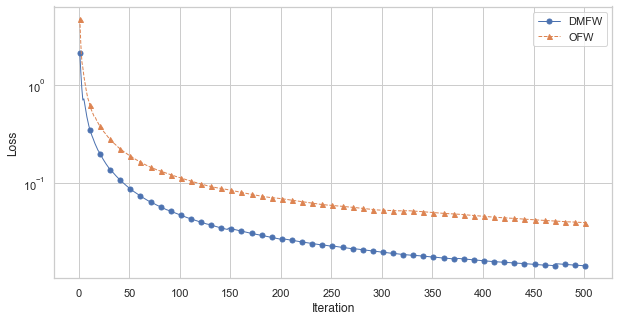

In [9]:
path_dmfw = os.path.join(analysis,"new-temp/cycle/alpha099/")
plotOFW(7, 'cycle','temp', path_dmfw, analysis, save_path_fig, save=True, metric='loss',average=True, indep_loss=False)

In [10]:
#plotDeFW(4, "cycle","temp",analysis,save_path_fig,save=False,metric="loss", average=True)

# Mapping 

In [11]:
graph_type = "line/"
path_ac_power = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/new-temp/complete/alpha085-250-relu/"

In [12]:
def plotDMFW(path,path_to_save,metric,floor_idx, save=False):
    data = read_result_from_csv(path)
    key = [ele for ele in data.keys()][0]
    print(data)
    #print(np.mean(data[str(floor_idx)][metric][:-1]))
    plt.figure(figsize=(10,5))
    plt.plot(data[key][metric][1:-1],label="DMFW"+f' {metric}')#,marker='o', markersize=5,
                     #markevery=[i for i in range(504) if i%10==0], linewidth=1)
    if metric == "Loss":
        plt.plot(average_loss(data[key][metric][:-1]),ls='--',label="DMFW Online"+f' {metric}')#,marker='^', markersize=5,
                         #markevery=[i for i in range(504) if i%10==0], linewidth=1)
    plt.xticks(ticks=np.arange(len(data[key][metric][:-1]),step=50))
    plt.legend()
    plt.ylabel(metric,**hfont)
    plt.xlabel("Iteration",**hfont)
    plt.yscale("log")
    if save:
        plt.savefig(path_to_save+f'{metric}-F{floor_idx}')
    plt.show()

In [73]:
def plotPrediction(path, path_to_save,feature,zone_idx, floor_idx,begin,end, save=False):
    files = os.listdir(path)

    prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx) and (floor_idx in file)]
    #print(prediction_files)
    if prediction_files == []:
        print("---Failed to read floor index---")
        prediction_files = [file for file in files if (file.startswith("prediction")) and (file.split(".")[0][-1]==zone_idx)]
    print(prediction_files)
    resultpd = pd.read_csv(path+prediction_files[0],index_col=0)
    result_to_plot = resultpd.iloc[begin:end]
    mean = np.mean(np.abs(result_to_plot["Truth"]-result_to_plot["Prediction"]))
    std = np.std(np.abs(result_to_plot["Truth"]-result_to_plot["Prediction"]))
    plt.figure(figsize=(15,5))
    plt.title(f'Floor {floor_idx} - Zone {zone_idx}')
    plt.plot(result_to_plot["Truth"],label="Truth")
    plt.plot(result_to_plot["Prediction"],label=f"Prediction-MAE:{mean:.4f}-STD:{std:.4f}",ls='-')
    #plt.xticks(ticks=np.arange(result_to_plot.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    if save:
        plt.savefig(path_to_save+f'prediction-F{floor_idx}-zone{zone_idx}')
    plt.show()

In [11]:
def compare_alpha(path_graph):
    folders = os.listdir(path_graph)
    alphas = [ele for ele in folders if len(ele)==8]
    alphas_dict = {}
    for alpha in alphas:
        direct = os.path.join(path_graph,alpha+"/")
        alphas_dict[alpha] = read_result_from_csv(direct)
    return alphas_dict

In [12]:
def plot_loss_alphas(alphas_dict, alphas_value=None):
    plt.figure(figsize=(10,4))
    for keys in alphas_dict.keys():
        print(f'{keys} : {np.mean(alphas_dict[keys]["7"]["Loss"][:-1])}')
        plt.plot(average_loss(alphas_dict[keys]["7"]["Loss"][:-1]),label=keys)
        plt.legend()
        plt.yscale("log")
    print("-----------------")
    
def compare_alphas_graph(complete_dict, cycle_dict, line_dict, alpha_value):
    alpha_str = f'alpha0{alpha_value}'
    plt.figure(figsize=(10,4))
    print(f'Complete : {np.mean(complete_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Cycle : {np.mean(cycle_dict[alpha_str]["7"]["Loss"][:-1])}')
    print(f'Line : {np.mean(line_dict[alpha_str]["7"]["Loss"][:-1])}')
    plt.plot(average_loss(complete_dict[alpha_str]["7"]["Loss"][:-1]), label="Complete "+alpha_str)
    plt.plot(average_loss(cycle_dict[alpha_str]["7"]["Loss"][:-1]), label="Cycle "+alpha_str)
    plt.plot(average_loss(line_dict[alpha_str]["7"]["Loss"][:-1]), label="Line "+alpha_str)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Average Loss")
    plt.yscale("log")

In [22]:
alpha_value = 95
zone = 1
nb_timestep = 288

In [23]:
cycle8zone = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version1/cycle/8Zone/alpha095--2layer-hid60/"
complete8zone = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/8Zone/alpha095-rsm-mean-cut20april/"
#complete8zone2 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version1/complete/8Zone/alpha095-rsm-mean-cut20april//"
line8zone = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version1/line/8Zone/alpha095--2layer-hid60/"

In [39]:
def compare_prediction_zone(path, floor, zone_idx):
    graph_type = ["complete","cycle","line"]
    zone_name = f'Floor{floor}Z{zone_idx}'
    cible_files = []
    result_pd = pd.DataFrame()
    for graph in graph_type:
        path_graph = os.path.join(path, f'{graph}/67Zone/alpha095-cut20april-hid64-64/')
        files = os.listdir(path_graph)
        zone_pred = [file for file in files if zone_name in file]
        path_csv = os.path.join(path_graph, zone_pred[0])
        graph_result = pd.read_csv(path_csv, index_col=0)
        result_pd = pd.concat([result_pd, graph_result["Truth"].rename(f'Truth {graph}') ,graph_result["Prediction"].rename(f'{graph}')],axis=1)
    return result_pd

def plot_compare_prediction(path, floor, zone_idx, start=0, end=-1):
    dataframe = compare_prediction_zone(path, floor, zone_idx)
    complete_mean, complete_std = np.mean(np.abs(dataframe["Truth complete"][start:end]-dataframe["complete"][start:end])),\
                                    np.std(dataframe["Truth complete"][start:end]-dataframe["complete"][start:end])
    cycle_mean, cycle_std = np.mean(np.abs(dataframe["Truth cycle"][start:end]-dataframe["cycle"][start:end])),\
                                    np.std(dataframe["Truth cycle"][start:end]-dataframe["cycle"][start:end])
    
    line_mean, line_std = np.mean(np.abs(dataframe["Truth line"][start:end]-dataframe["line"][start:end])),\
                                    np.std(dataframe["Truth line"][start:end]-dataframe["line"][start:end])
    #plt.boxplot(dataframe["Truth complete"])
    plt.figure(figsize=(15,5))
    plt.title(f'Floor {floor} - Zone {zone_idx}')
    plt.plot(dataframe["Truth complete"][start:end], label="Truth")
    plt.plot(dataframe["complete"][start:end], label=f"Prediction Complete - MeanAE:{complete_mean:.4f} - Std:{complete_std:.4f}")
    plt.plot(dataframe["cycle"][start:end], label=f"Prediction Cycle - MeanAE:{cycle_mean:.4f} - Std:{cycle_std:.4f}")
    plt.plot(dataframe["line"][start:end], label=f"Prediction Line - MeanAE:{line_mean:.4f} - Std:{line_std:.4f}")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()
    
#def compare_loss_zone(path,log)

In [35]:
global_path2 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/67Zone/alpha095-cut20april-hid64-64/"
def truth_distribution(path):
    files = os.listdir(path)
    predictions = sorted([file for file in files if "prediction" in file])
    selected = pd.DataFrame()
    for pred in predictions:
        csv = pd.read_csv(global_path2+pred,index_col=0)
        selected = pd.concat([selected,csv["Truth"].rename(f"{pred}".split("-")[1].split(".")[0])],axis=1)
    return selected
truths = truth_distribution(global_path2)

<AxesSubplot:>

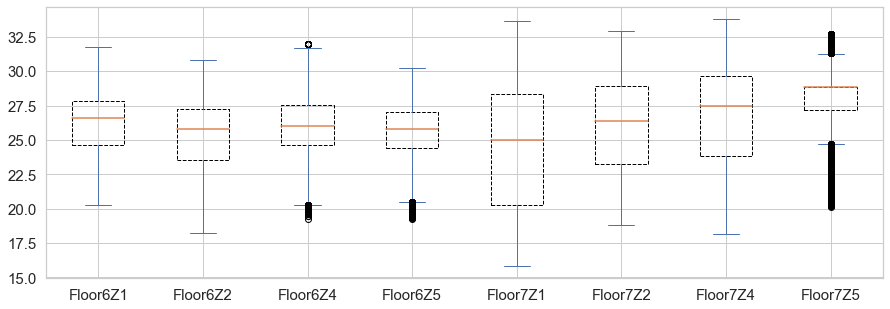

In [36]:
truths.plot(kind="box",figsize=(15,5),
            grid=True,
            fontsize=15,
            #color=dict(medians='r',whiskers='r'),
            boxprops=dict(linestyle='--', linewidth=1.),
            medianprops=dict(linestyle='-', linewidth=1.5))

['prediction-Floor6Z1.csv']
Means 0.7657010262896825
Std 0.7619397920352722


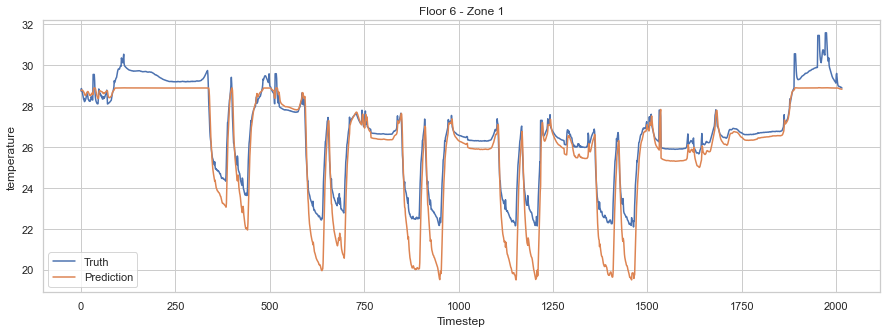

['prediction-Floor6Z1.csv']
Means 0.9566229394841271
Std 0.7264306824964186


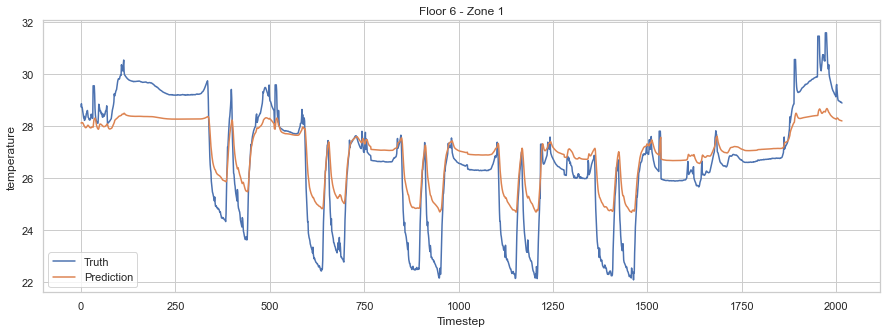

['prediction-Floor6Z1.csv']
Means 0.7468225972222221
Std 0.4547169643582478


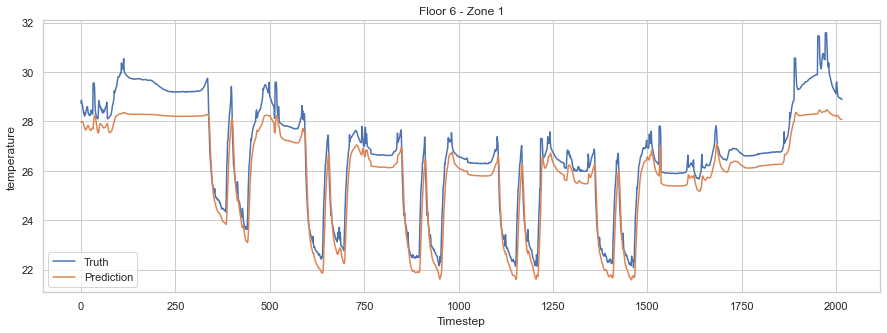

['prediction-Floor6Z1.csv']
Means 0.45098512103174604
Std 0.32115206328724866


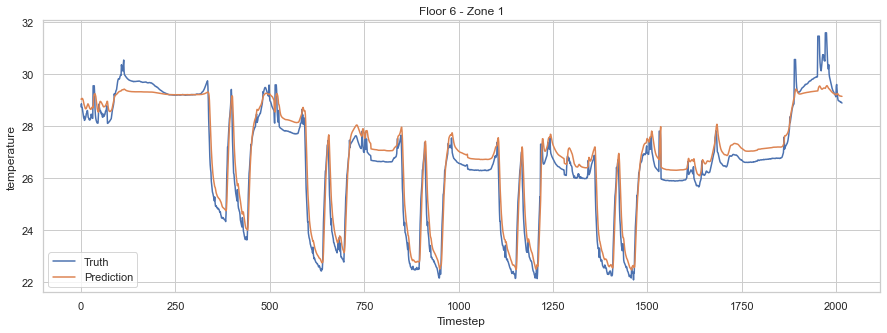

['prediction-Floor7Z1.csv']
Means 2.3437694558531743
Std 1.2457364026457658


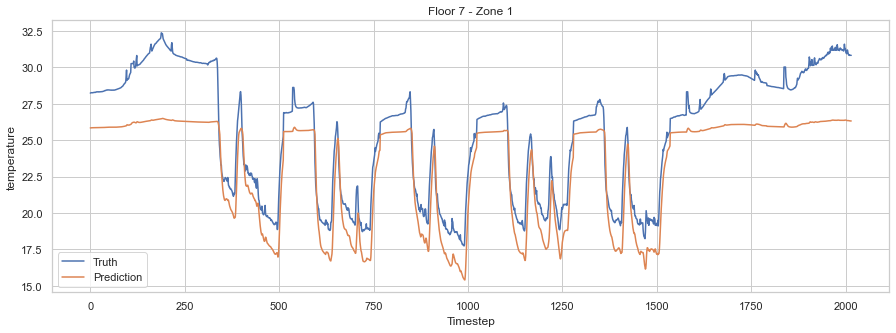

['prediction-Floor7Z1.csv']
Means 0.7306178239087302
Std 0.7344071167569608


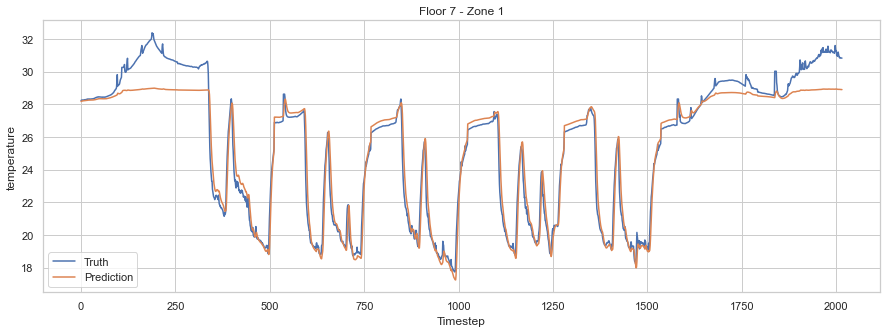

['prediction-Floor6Z1.csv']
Means 0.6981585922619047
Std 0.3824944474935878


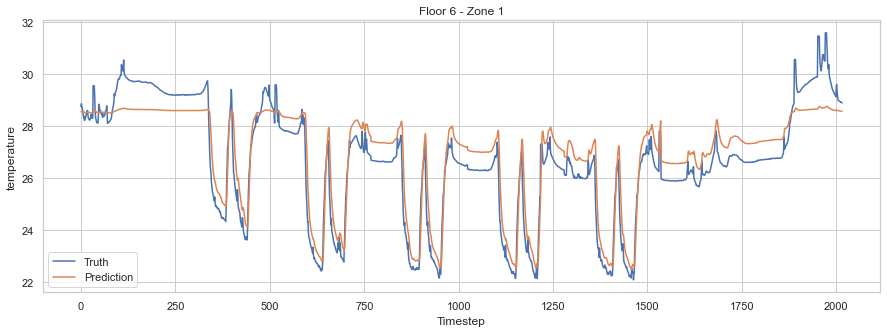

In [45]:
oneweek = 288*7#hehe = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-rsm-mean-cut20april/"
hehe2 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-rsm-cut20april-shuffle-1layer/"
hehe3 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-rsm-cut20april-shuffle-2layer-hid64-96/"
hehe4 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-rsm-cut20april-shuffle-2layer-hid60/"
hehe5 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-rsm-cut20april-shuffle-2layer-hid60-72/"
hehe6 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-Floor7Z1-cut20april-shuffle-2layer-hid64-72/"
hehe7 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-Floor7Z1-cut20april-shuffle-2layer-hid64-64/"
hehe8 = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/grid11/8Zone/alpha095-Floor6Z1-cut20april-shuffle-2layer-hid64-64/"
#plotPrediction(hehe, None, "temperature",str(1),"6",2300,nb_timestep)
plotPrediction(hehe2, None, "temperature",str(1),"6",0,oneweek)
plotPrediction(hehe3, None, "temperature",str(1),"6",0,oneweek)
plotPrediction(hehe4, None, "temperature",str(1),"6",0,oneweek)
plotPrediction(hehe5, None, "temperature",str(1),"6",0,oneweek)
plotPrediction(hehe6, None, "temperature",str(1),"7",0,oneweek)
plotPrediction(hehe7, None, "temperature",str(1),"7",0,oneweek)
plotPrediction(hehe8, None, "temperature",str(1),"6",0,oneweek)

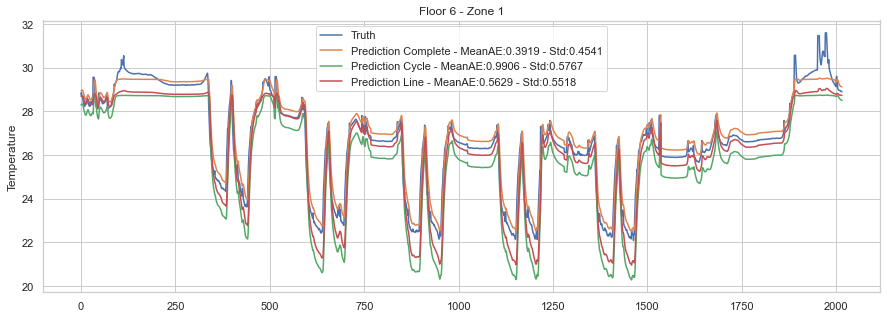

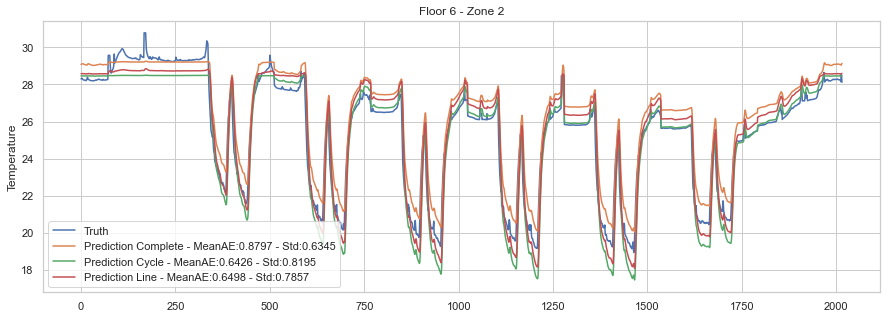

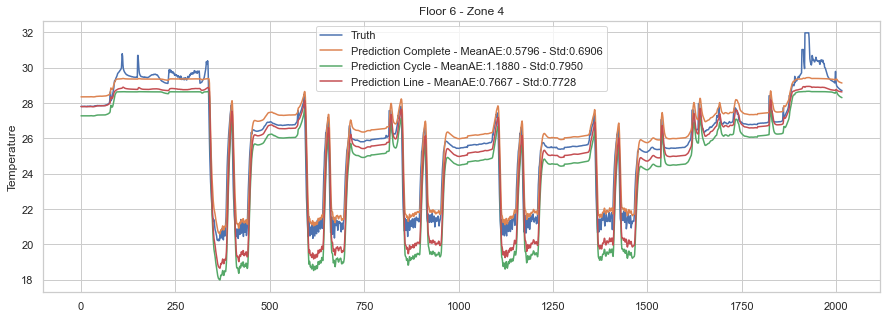

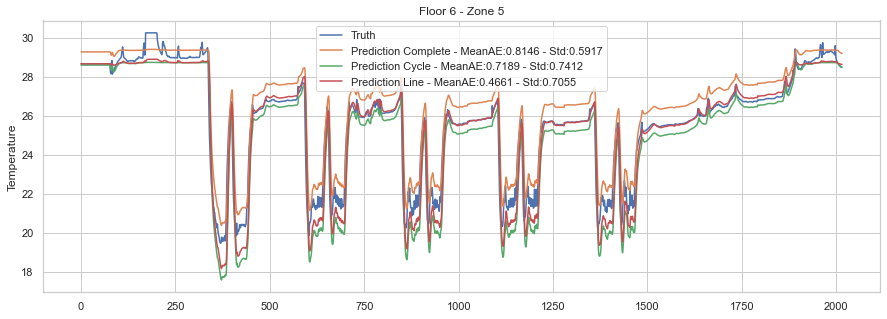

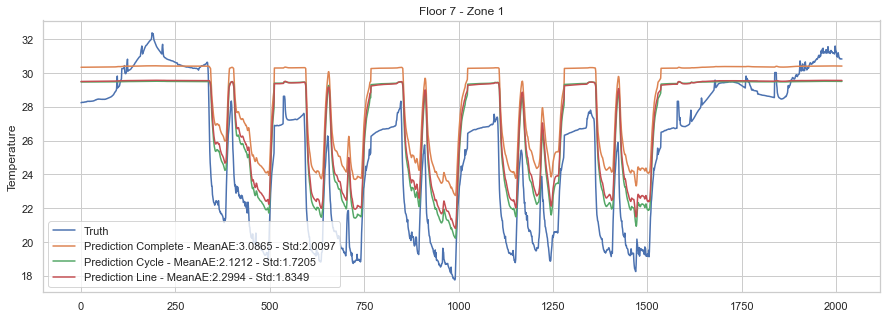

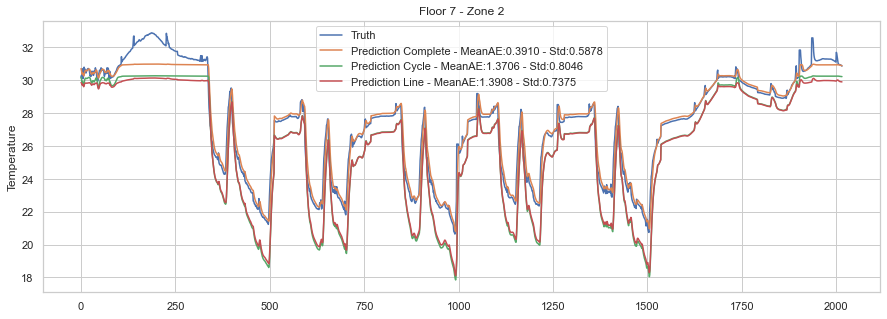

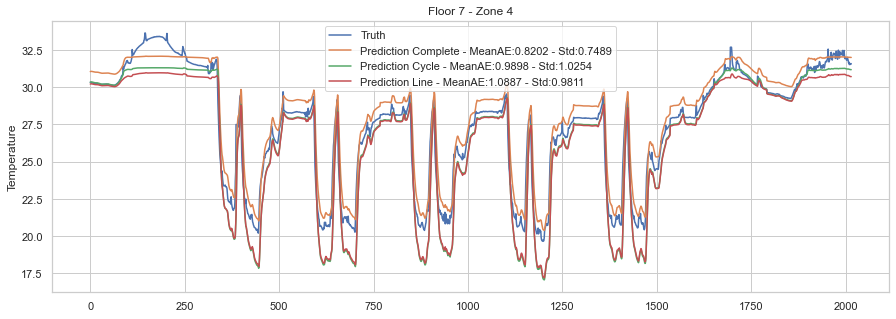

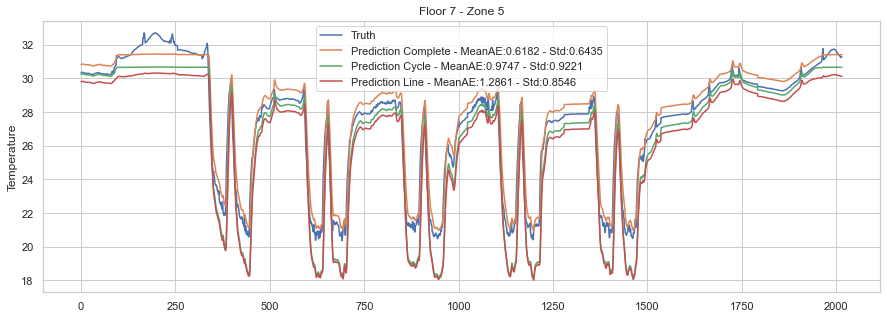

In [42]:
global_path = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/"
for floor in [6,7]:
    for zone in [1,2,4,5]:
        plot_compare_prediction(global_path, floor, zone, 0, 7*nb_timestep)

['prediction-Floor6Z1.csv']
Means 0.882368491898148
Std 0.45931943693347965


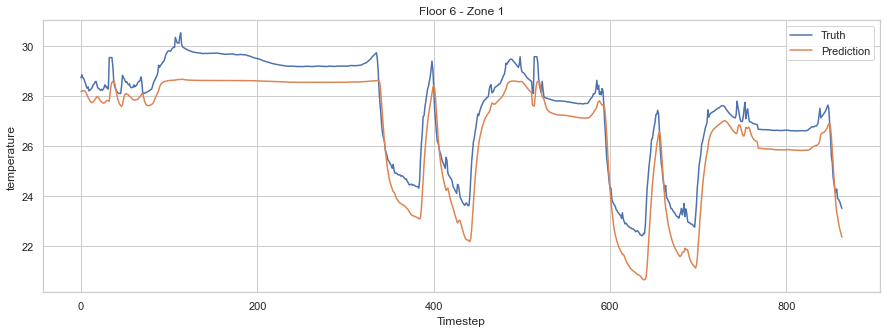

['prediction-Floor7Z1.csv']
Means 2.117860966435185
Std 1.0567005849809672


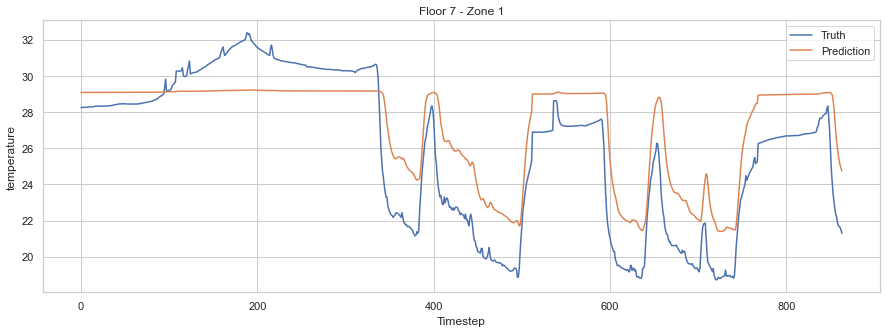

['prediction-Floor6Z2.csv']
Means 1.0669357372685184
Std 0.5884710385254184


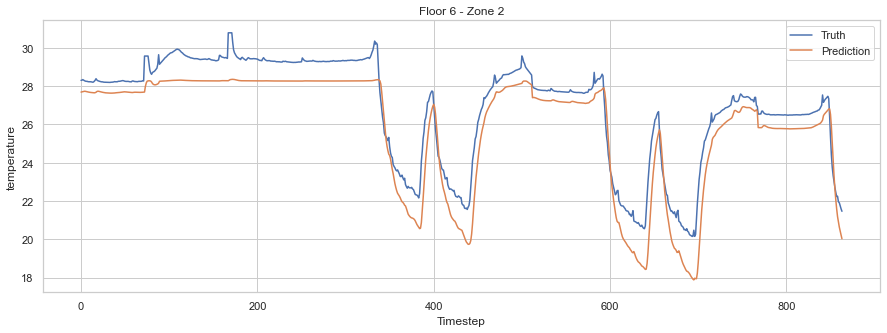

['prediction-Floor7Z2.csv']
Means 1.3340425358796297
Std 0.7400070386502456


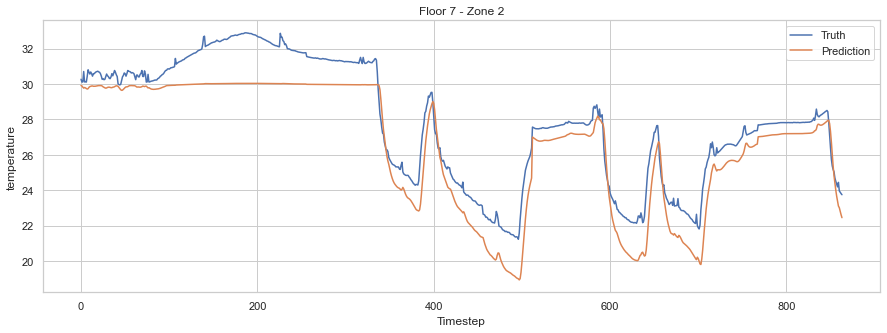

['prediction-Floor6Z4.csv']
Means 0.8150088055555555
Std 0.590381818597197


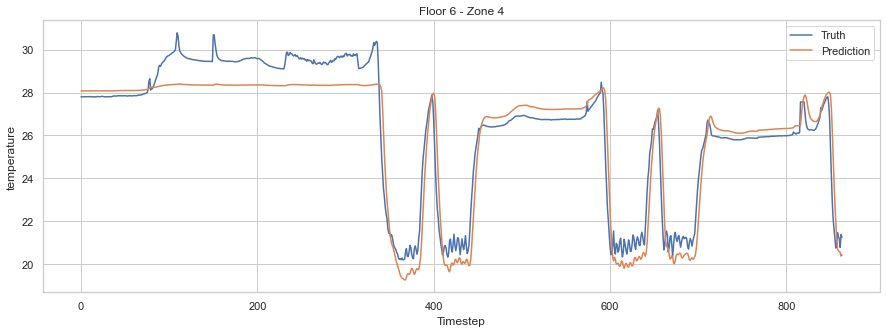

['prediction-Floor7Z4.csv']
Means 0.9725468113425927
Std 0.8609651898528489


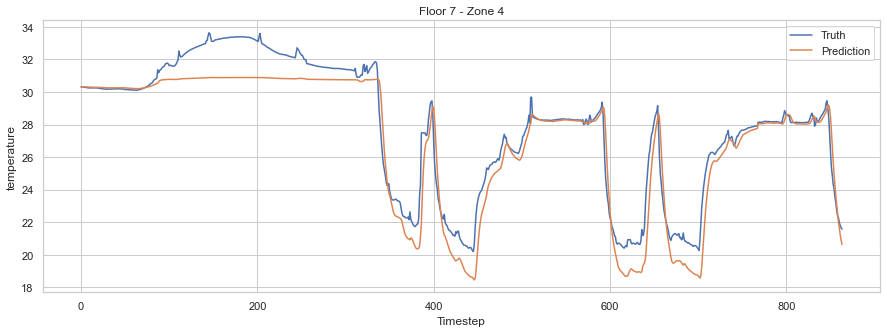

['prediction-Floor6Z5.csv']
Means 0.6446132233796296
Std 0.6535337398583724


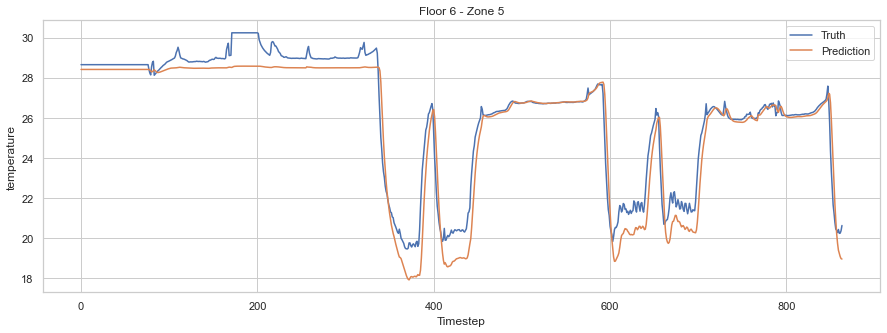

['prediction-Floor7Z5.csv']
Means 1.1772284224537037
Std 0.7951311923274343


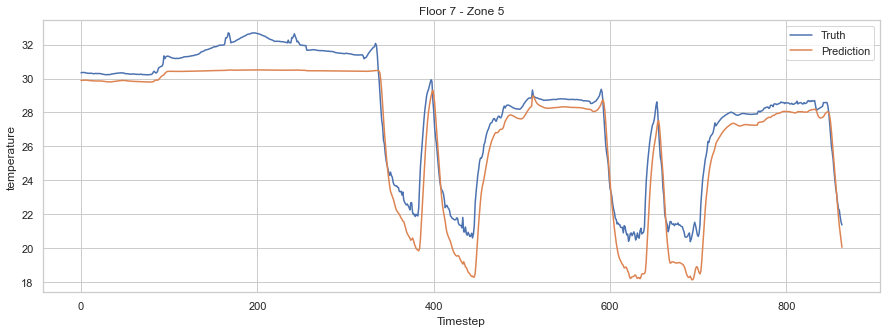

In [47]:

permute = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/cycle/67Zone/alpha095-cut20april-hid64-64-permutzones/"
for zone in [1,2,4,5]:
    plotPrediction(permute,None,"temperature",str(zone),"6",0,3*nb_timestep)
    plotPrediction(permute,None,"temperature",str(zone),"7",0,3*nb_timestep)

In [79]:
three_zones = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version3/complete/567Zone/alpha095-cut20april-hid64-64/"

['prediction-Floor7Z1.csv']


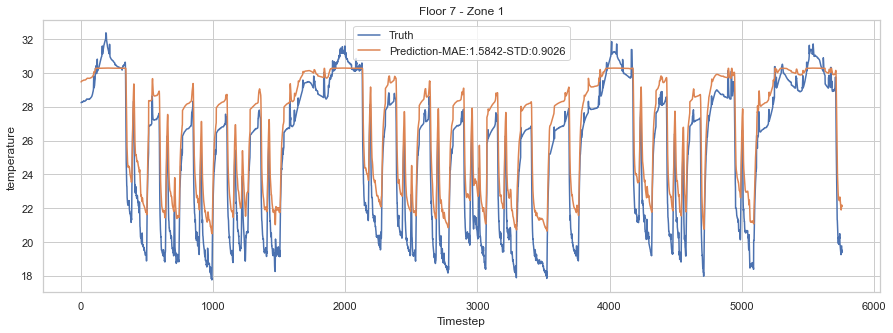

['prediction-Floor7Z2.csv']


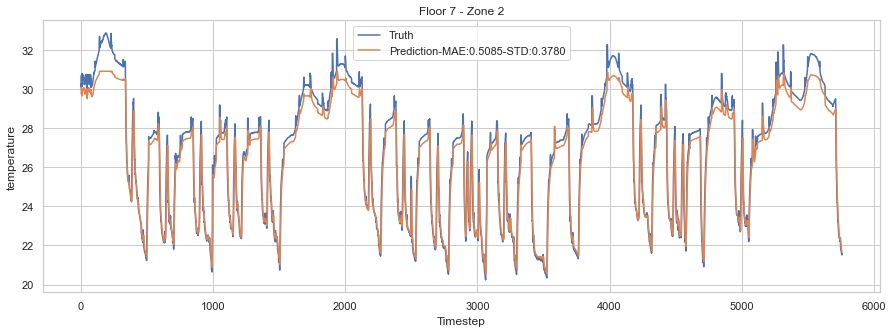

['prediction-Floor7Z4.csv']


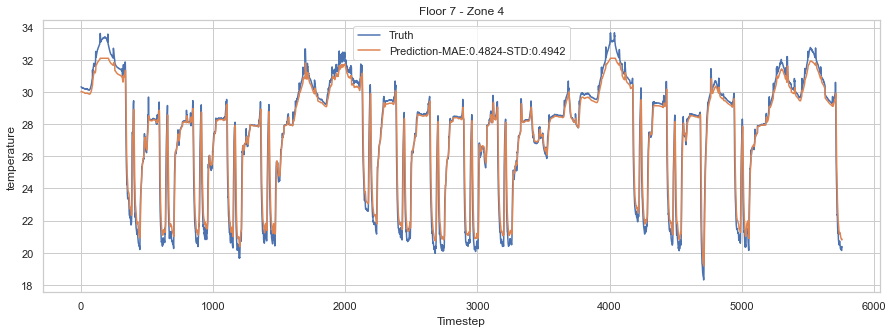

['prediction-Floor7Z5.csv']


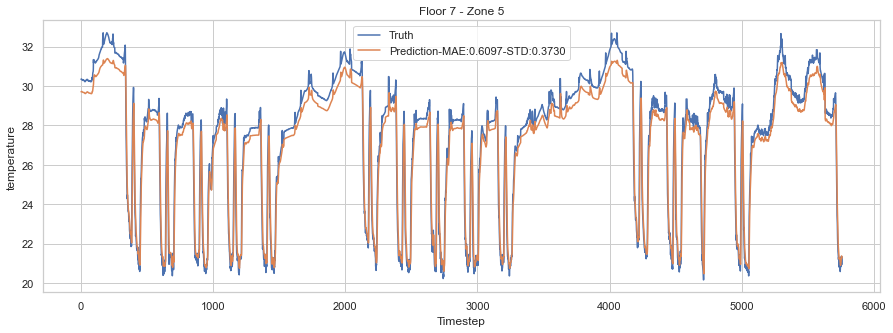

In [80]:
for zone in [1,2,4,5]:
    plotPrediction(three_zones,None,"temperature",str(zone),"7",0,20*nb_timestep)

# Evaluate GridSearch F7Z1

---Hidden Unit 40---
['prediction-zone1.csv']
Means 2.0474284253472224
Std 1.0466807613469995


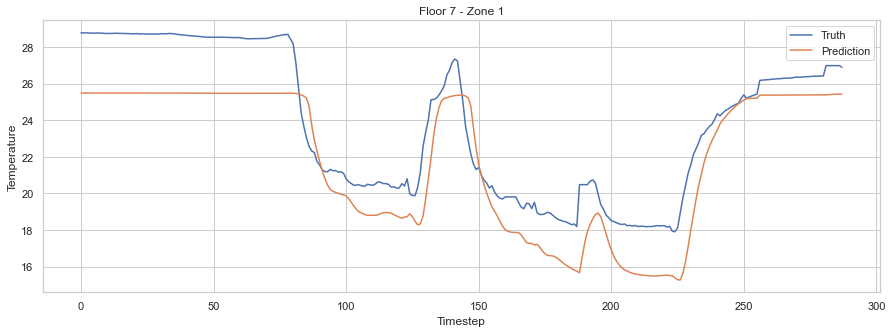

---Hidden Unit 64---
['prediction-zone1.csv']
Means 1.6010306875
Std 1.4285696322813357


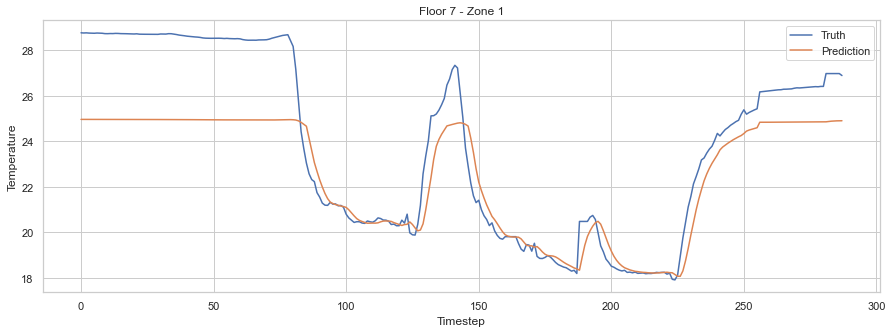

---Hidden Unit 128---
['prediction-zone1.csv']
Means 1.5372073159722222
Std 0.8840787438486583


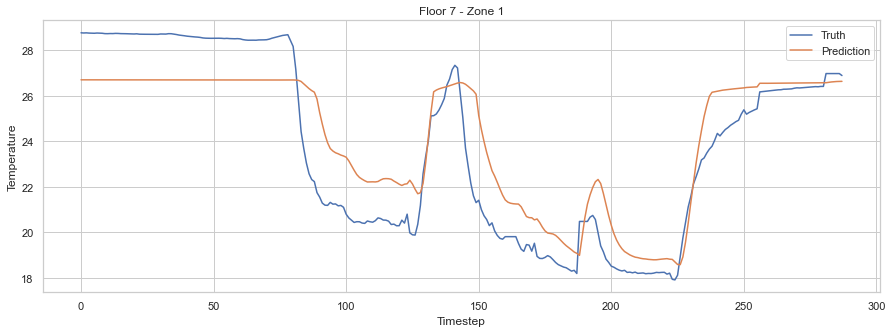

In [43]:
for value in [40,64,128]:
    print(f'---Hidden Unit {value}---')
    path_grid11 = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version1/grid11/SingleZone/alpha095-hid{value}-withtime/"
    plotPrediction(path_grid11,None,"Temperature",str(1),"7",0,nb_timestep)